In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,7)

## Step 0
### Data Acquisition

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"]  # type: ignore

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
rets

Ticker,SPY,XLE,XOP,GDX,GLD,IYW,XLK
Date,,,,,,,
2017-01-04,0.005932,-0.002103,0.004749,0.007326,0.003524,0.004447,0.003478
2017-01-05,-0.000795,-0.002503,-0.003084,0.056753,0.015396,0.001560,0.001633
2017-01-06,0.003571,0.000923,-0.007395,-0.035538,-0.007400,0.009472,0.007314
2017-01-09,-0.003306,-0.014601,-0.028410,0.003121,0.008199,0.002841,-0.000202
2017-01-10,0.000000,-0.009134,0.000000,0.007099,0.004251,0.000324,0.000202
...,...,...,...,...,...,...,...
2021-12-27,0.014053,0.021622,0.039652,0.000958,0.002364,0.020187,0.021225
2021-12-28,-0.000818,-0.000713,-0.008699,-0.007690,-0.004319,-0.008060,-0.005221
2021-12-29,0.001278,-0.006442,-0.004072,0.004173,-0.000297,-0.000431,0.000853


## Step 2

### Describe the complete pair strategy adopted, composed of: (a) a baseline strategy based on the co-integrated spread of the chosen ETF pair trade, and (b) an added volatility regime-switching indicator, that activates the baseline strategy only when within the low-volatility regime.

#### Description of the volatility regime-switching indicator

In [ ]:
# b add volatility-switch indicator to the strategy
# from step 1c
mod_spy = sm.tsa.MarkovAutoregression(rets["SPY"], k_regimes=2, order=1, trend='c', switching_ar=True, switching_variance=True)

# halflife
tau_days = np.array([10.5, 21]) # SPY returns half-revert in 10 days when low vol, in 21 when high vol
business_year_in_days = 252
tau = tau_days / business_year_in_days
# UO's mean reversion adapted to AR(1)'s beta
log2 = np.log(2)
kappa = log2 / tau
beta = np.exp(-kappa / business_year_in_days)

mu = [0.0005, -0.0010]
alpha = mu * (1 - beta)

sigma = [0.008, 0.02]

# rough estimation of logit^-1(transition probabilities)
P = np.array([0.9, 0.5])
logit = np.exp(P)/(1 + np.exp(P))

start = mod_spy.start_params.copy()
start[:2] = logit       # logit(P)       # mu guesses: calm 20 bp, stress 200 bp
start[2:4] = alpha  # mu          # beta guesses: kappa approx 2.3 /yr vs 1.0 /yr
start[4:6] = np.square(sigma)           # sigma guesses
# logit(P00) ~ 2.5  -> P00 approx 0.92 ; logit(P11) ~ 0   -> P11 approx 0.5
start[6:8] = beta  # beta

# bounds:   alpha ≥ 0,   0.70 <= beta <= 0.95,   sigma ≥ 1e‑3,   transition logits free
b = [(0.25, 0.931), (0.25, 0.931), #(0.5, 0.731), (0.5, 0.731), # P         # mu
	(-0.001, 0.1), (-0.001, 0.1), #(-0.01, 0.01), (-0.01, 0.01), # mu   # beta
	(1e-3, 1e6), (1e-3, 1e6),    # sigma
	(0.50, 1.3), (0.50, 1.3)]  #beta  # logits of P

np.random.seed(1234)
spy_markov_results = mod_spy.fit(start_params=start, bounds=b, method="bfgs", maxiter=500, search_reps=20)

Average duration of each regime:
Calm regime: 43.050  days
Stressed regime:  15.630 days


In [ ]:
# high vol regime indicator to be used inside pair strategy
switch_high_vol = spy_markov_results.smoothed_marginal_probabilities[0] > 0.9
# switch_high_vol 

Date
2017-01-05    False
2017-01-06    False
2017-01-09    False
2017-01-10    False
2017-01-11    False
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31    False
Name: 0, Length: 1257, dtype: bool

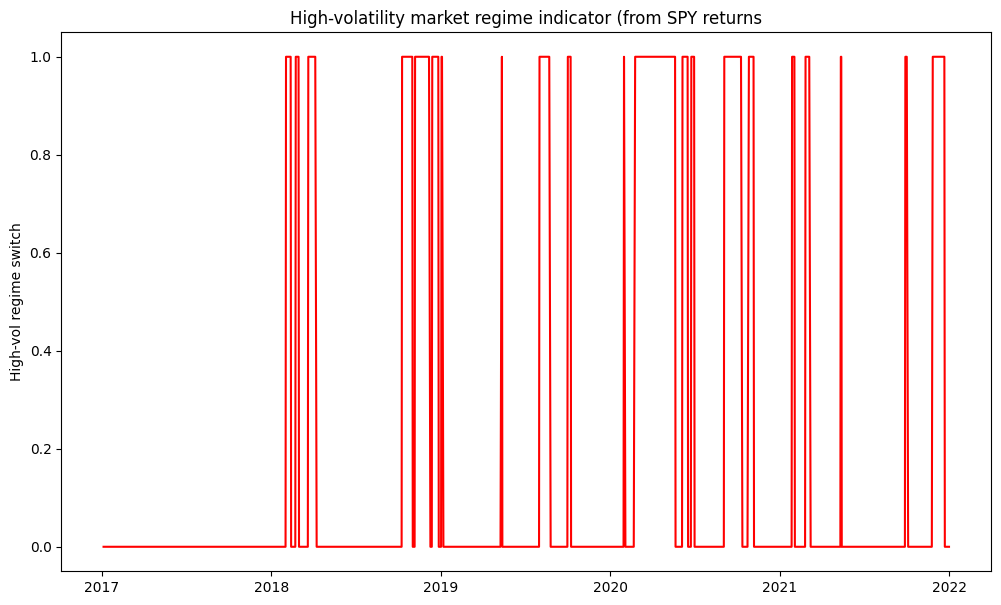

In [ ]:
#fig, axes = plt.subplots(2)

# ax = axes[0]
# ax.plot(spy_markov_results.smoothed_marginal_probabilities[1],'g')
# ax.set(title="Probability of a low-volatility regime for SPY returns")

plt.plot(switch_high_vol,'r')
plt.title("High-volatility market regime indicator (from SPY returns)")
plt.ylabel("High-vol regime switch")
plt.show()

#### Strategy 1: Energy ETFs

In [3]:
# OLS regression and spread
y = prices["XLE"]
X = sm.add_constant(prices["XOP"])
model_energy = sm.OLS(y, X).fit()
alpha_energy, beta_energy = model_energy.params
spread_energy = y - (alpha_energy + beta_energy * prices["XOP"])
spread_energy.name = "Spread"
# print("XLE on XOP Regression beta coefficient: ", beta_energy)

In [14]:
# a. baseline strategy
roll_window = 63 # trimestral
zscore_energy = (spread_energy - spread_energy.rolling(roll_window).mean()) / spread_energy.rolling(roll_window).std()
long_entry  = zscore_energy <= -2
short_entry = zscore_energy >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_energy) != np.sign(zscore_energy.shift()) #or (zscore_energy.abs() < 0.1) #zscore_energy.abs() < 0.5
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_energy.abs() < 0.1)

position_energy_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_energy_no_switch = pd.Series(position_energy_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_energy_no_switch = position_energy_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy_no_switch.name = "Spread Position"
# position_energy

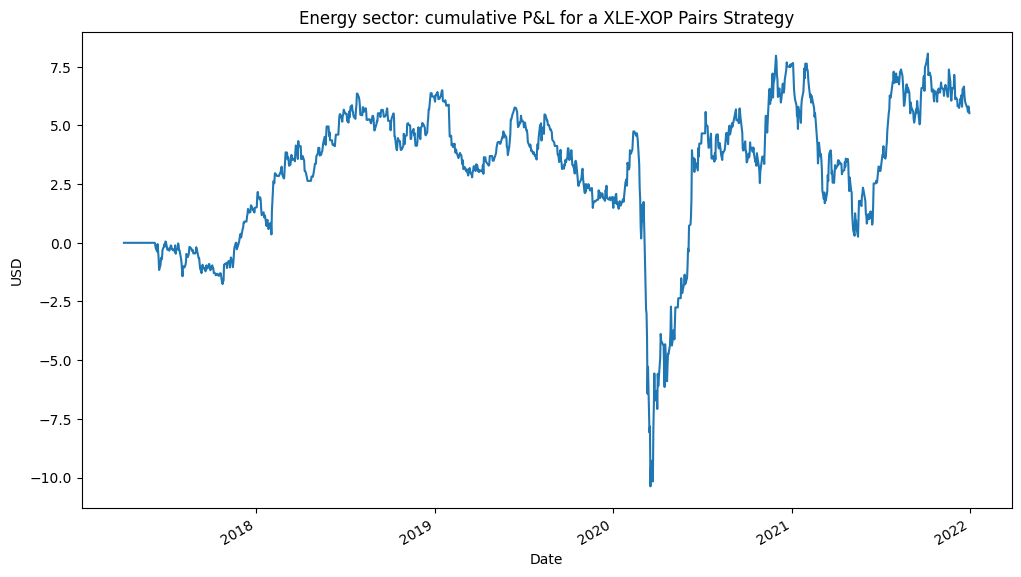

Annualised Sharpe for Energy sector pair strategy ≈ 0.19


In [15]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy_no_switch.shift() * spread_returns
cum_pnl_energy_no_switch = strategy_ret.cumsum()
cum_pnl_energy_no_switch.name = "PnL Energy pair"

# Results
fig, ax = plt.subplots()
cum_pnl_energy_no_switch.plot(ax=ax, title="Energy sector: cumulative P&L for a XLE-XOP Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_energy_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy_no_switch:.2f}")

In [ ]:
# apply vol switch to trading strategy 
position_energy_with_switch = position_energy_no_switch.where(~switch_high_vol, 0)

#position_energy_with_switch = position_energy_with_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy_with_switch.name = "Spread Position"
# position_energy_with_switch

Date
2017-04-04    0.0
2017-04-05    0.0
2017-04-06    0.0
2017-04-07    0.0
2017-04-10    0.0
             ... 
2021-12-27   -1.0
2021-12-28   -1.0
2021-12-29   -1.0
2021-12-30   -1.0
2021-12-31   -1.0
Name: Spread Position, Length: 1196, dtype: float64

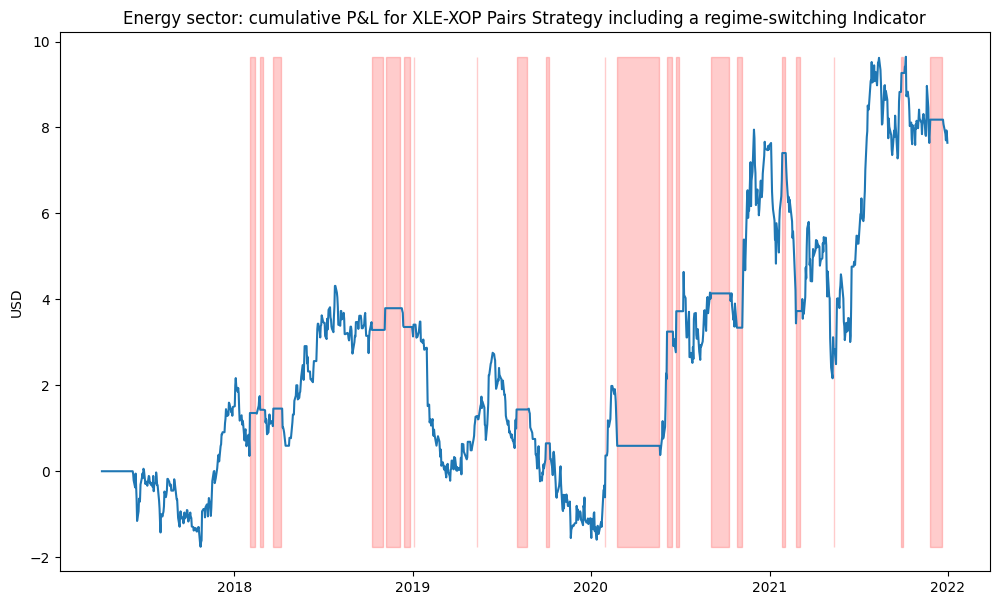

Annualised Sharpe for Energy sector pair strategy ≈ 0.39


In [19]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy_with_switch.shift() * spread_returns
cum_pnl_energy_with_switch = strategy_ret.cumsum()
cum_pnl_energy_with_switch.name = "PnL Energy pair"

min_pnl = cum_pnl_energy_with_switch.min()
max_pnl = cum_pnl_energy_with_switch.max()
# Results
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch)
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Energy sector: cumulative P&L for XLE-XOP Pairs Strategy including a regime-switching Indicator")
plt.show()

annual_sharpe_energy_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy_with_switch:.2f}")

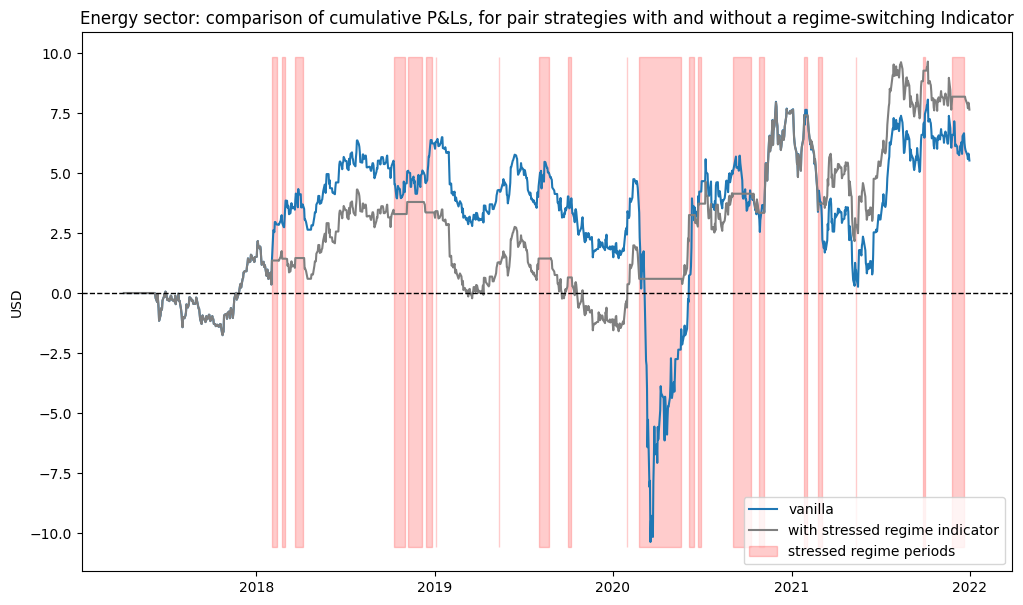

In [38]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_energy_with_switch.min(), cum_pnl_energy_no_switch.min())
max_pnl = max(cum_pnl_energy_with_switch.max(), cum_pnl_energy_no_switch.max())

#plt.plot(cum_pnl_energy.index, cum_pnl_energy)
plt.plot(cum_pnl_energy_no_switch.index, cum_pnl_energy_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Energy sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="lower right")

plt.show()

#### Strategy 2: Gold ETFs

In [39]:
# OLS regression and spread
y = prices["GDX"]
X = sm.add_constant(prices["GLD"])
model_gold = sm.OLS(y, X).fit()
alpha_gold, beta_gold = model_gold.params
spread_gold = y - (alpha_gold + beta_gold * prices["GLD"])
spread_gold.name = "Spread"

In [40]:
# baseline strategy
roll_window = 63 # trimestral
zscore_gold = (spread_gold - spread_gold.rolling(roll_window).mean()) / spread_gold.rolling(roll_window).std()
long_entry  = zscore_gold <= -2
short_entry = zscore_gold >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_gold) != np.sign(zscore_gold.shift())
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_gold.abs() < 0.1)

position_gold_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_gold_no_switch = pd.Series(position_gold_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_gold_no_switch = position_gold_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_gold_no_switch.name = "Spread Position"
# position_gold

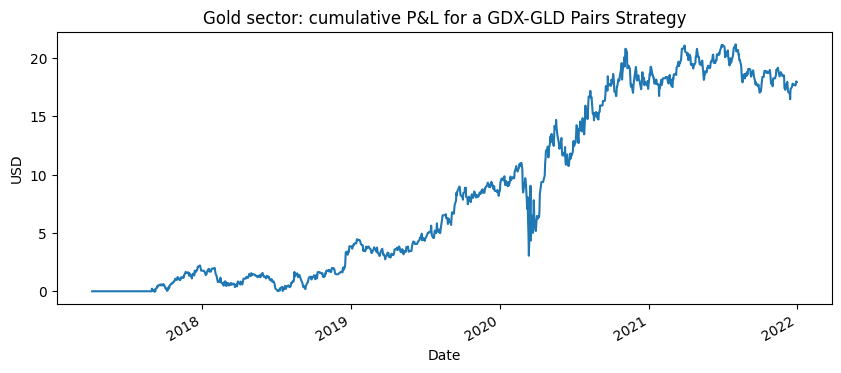

Annualised Sharpe for Gold sector pair strategy ≈ 0.61


In [ ]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold_no_switch.shift() * spread_returns
cum_pnl_gold_no_switch = strategy_ret.cumsum()
cum_pnl_gold_no_switch.name = "PnL Gold pair"

# Results
fig, ax = plt.subplots()
cum_pnl_gold_no_switch.plot(ax=ax, title="Gold sector: cumulative P&L for a GDX-GLD Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_gold_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold_no_switch:.2f}")

In [ ]:
# apply vol switch to trading strategy 
position_gold_with_switch = position_gold_no_switch.where(~switch_high_vol, 0)

position_gold_with_switch.name = "Spread Position"
# position_gold_with_switch

Date
2017-04-04    0.0
2017-04-05    0.0
2017-04-06    0.0
2017-04-07    0.0
2017-04-10    0.0
             ... 
2021-12-27    1.0
2021-12-28    1.0
2021-12-29    1.0
2021-12-30    1.0
2021-12-31    1.0
Name: Spread Position, Length: 1196, dtype: float64

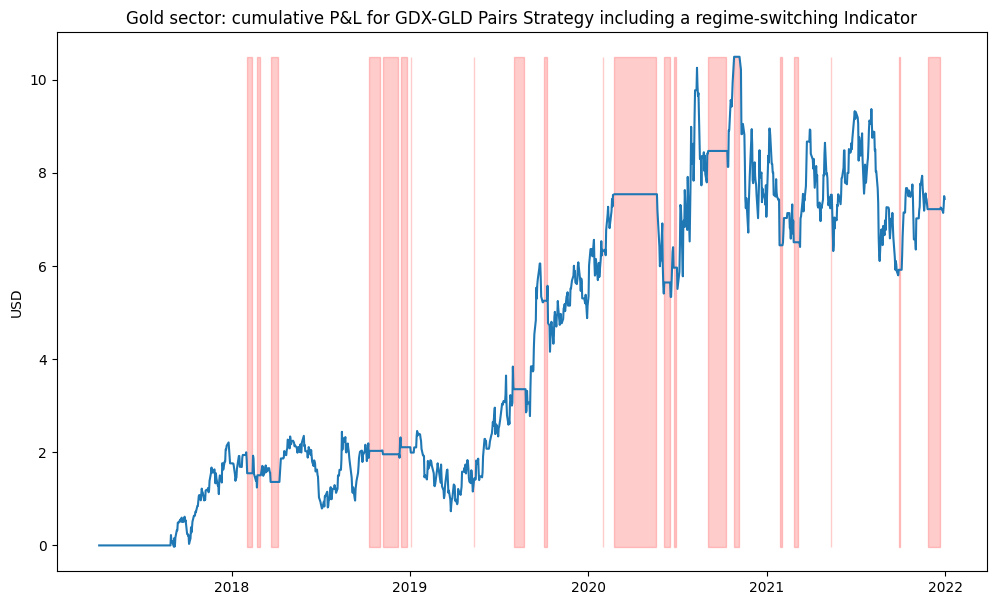

Annualised Sharpe for Gold sector pair strategy ≈ 0.40


In [43]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold_with_switch.shift() * spread_returns
cum_pnl_gold_with_switch = strategy_ret.cumsum()
cum_pnl_gold_with_switch.name = "PnL Gold pair"

min_pnl = cum_pnl_gold_with_switch.min()
max_pnl = cum_pnl_gold_with_switch.max()
# Results
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch)
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Gold sector: cumulative P&L for GDX-GLD Pairs Strategy including a regime-switching Indicator")
plt.show()

annual_sharpe_gold_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold_with_switch:.2f}")

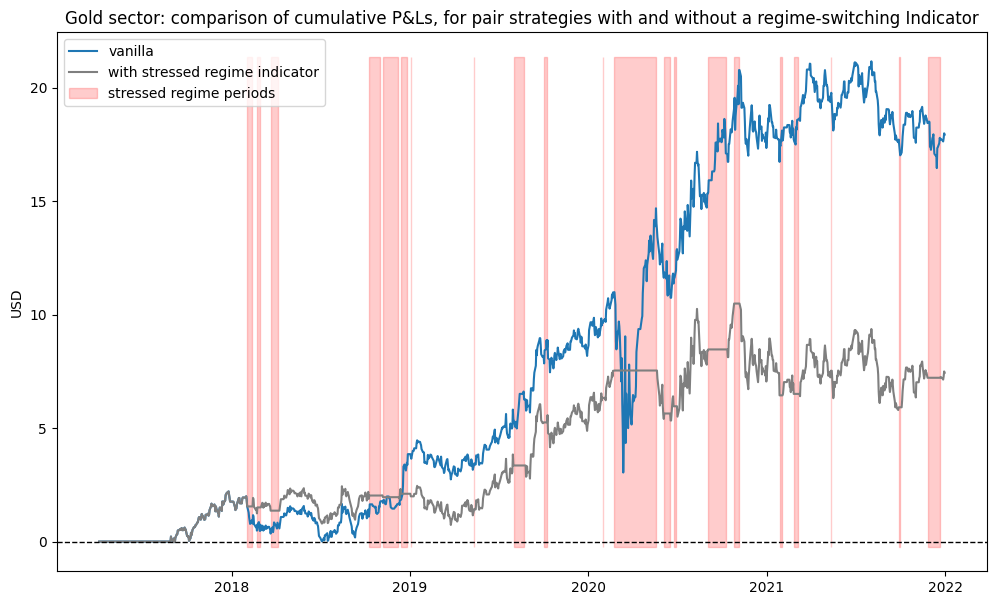

In [ ]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_gold_with_switch.min(), cum_pnl_gold_no_switch.min())
max_pnl = max(cum_pnl_gold_with_switch.max(), cum_pnl_gold_no_switch.max())

plt.plot(cum_pnl_gold_no_switch.index, cum_pnl_gold_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Gold sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="upper left")

plt.show()

#### Strategy 3: Technology ETFs

In [46]:
# OLS regression and spread
y = prices["IYW"]
X = sm.add_constant(prices["XLK"])
model_tech = sm.OLS(y, X).fit()
alpha_tech, beta_tech = model_tech.params
spread_tech = y - (alpha_tech + beta_tech * prices["XLK"])
spread_tech.name = "Spread"

In [47]:
# baseline strategy
roll_window = 63 # trimestral
zscore_tech = (spread_tech - spread_tech.rolling(roll_window).mean()) / spread_tech.rolling(roll_window).std()
long_entry  = zscore_tech <= -2
short_entry = zscore_tech >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_tech) != np.sign(zscore_tech.shift())
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_tech.abs() < 0.1)

position_tech_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_tech_no_switch = pd.Series(position_tech_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_tech_no_switch = position_tech_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_tech_no_switch.name = "Spread Position"
# position_tech

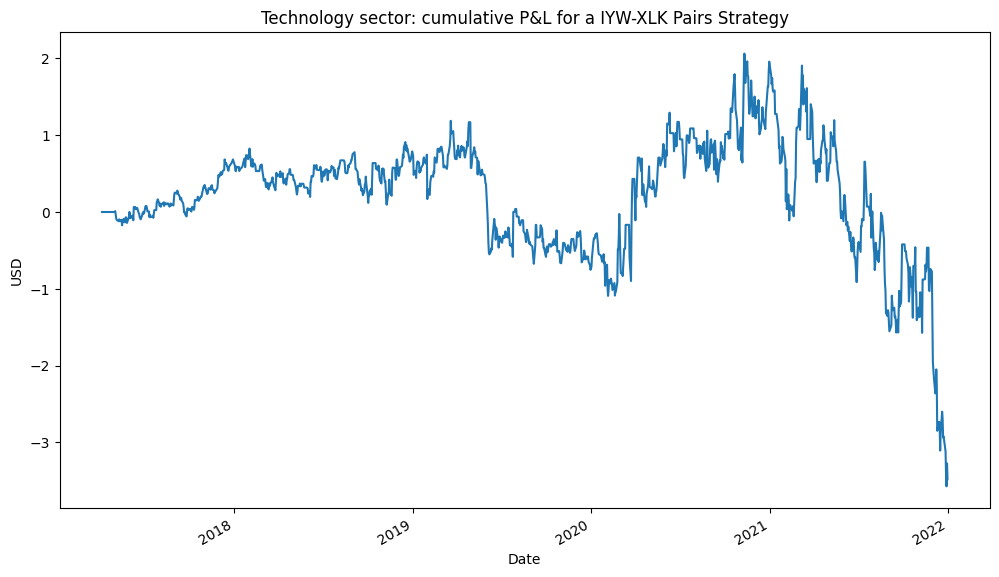

Annualised Sharpe for Technology sector pair strategy ≈ -0.31


In [48]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech_no_switch.shift() * spread_returns
cum_pnl_tech_no_switch = strategy_ret.cumsum()
cum_pnl_tech_no_switch.name = "PnL Technology pair"

# Results
fig, ax = plt.subplots()
cum_pnl_tech_no_switch.plot(ax=ax, title="Technology sector: cumulative P&L for a IYW-XLK Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_tech_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech_no_switch:.2f}")

In [49]:
# apply vol switch to trading strategy 
position_tech_with_switch = position_tech_no_switch.where(~switch_high_vol, 0)

position_tech_with_switch.name = "Spread Position"
# position_tech_with_switch

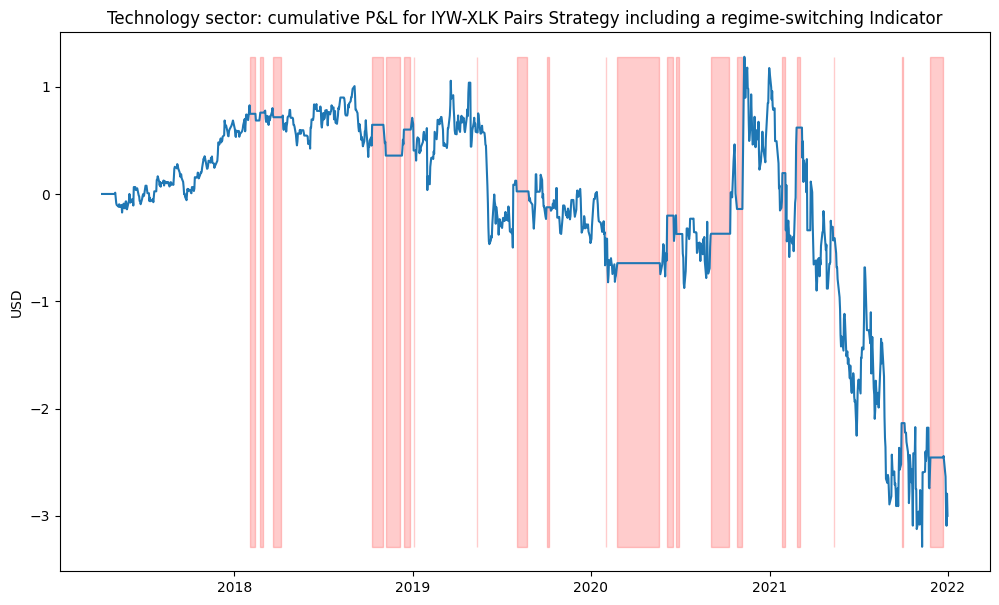

Annualised Sharpe for Technology sector pair strategy ≈ -0.32


In [50]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech_with_switch.shift() * spread_returns
cum_pnl_tech_with_switch = strategy_ret.cumsum()
cum_pnl_tech_with_switch.name = "PnL Technology pair"

min_pnl = cum_pnl_tech_with_switch.min()
max_pnl = cum_pnl_tech_with_switch.max()
# Results
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch)
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Technology sector: cumulative P&L for IYW-XLK Pairs Strategy including a regime-switching Indicator")
plt.show()

annual_sharpe_tech_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech_with_switch:.2f}")

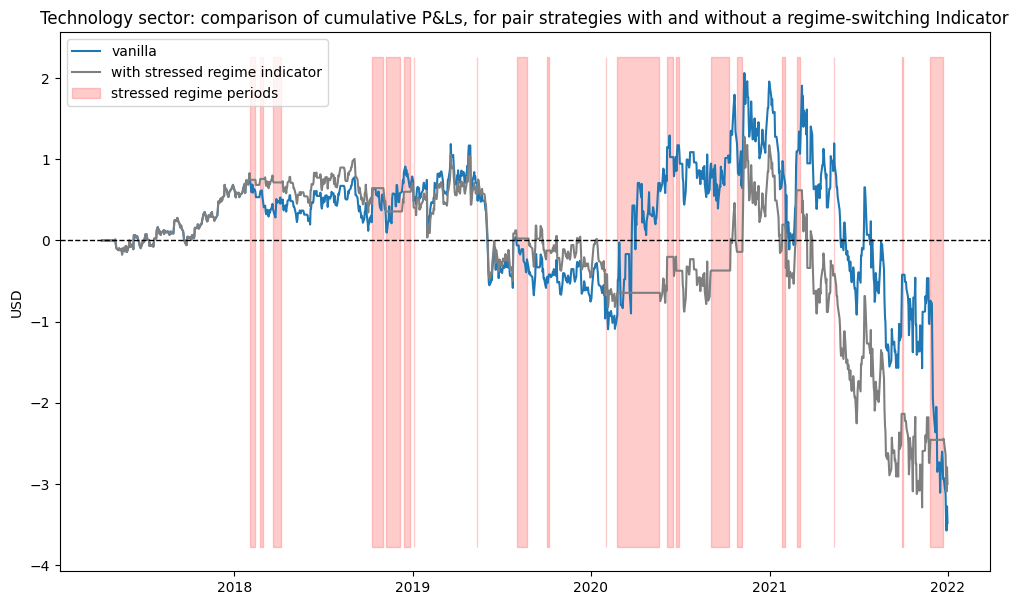

In [51]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_tech_with_switch.min(), cum_pnl_tech_no_switch.min())
max_pnl = max(cum_pnl_tech_with_switch.max(), cum_pnl_tech_no_switch.max())

plt.plot(cum_pnl_tech_no_switch.index, cum_pnl_tech_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Technology sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="upper left")

plt.show()

## Step 3

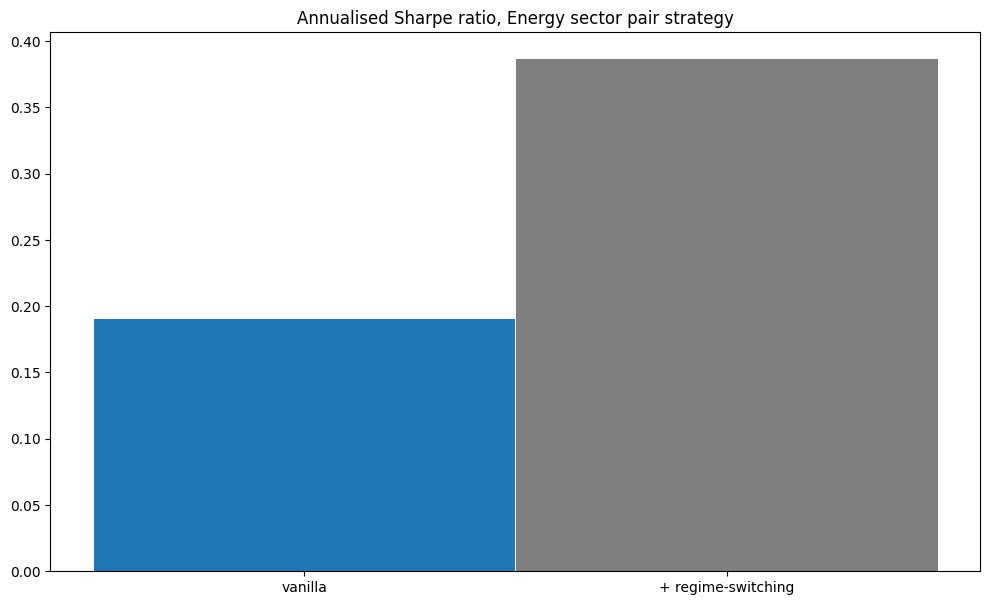

In [34]:
# compare annualised Sharpe ratios
x = ["vanilla", "+ regime-switching"] # np.arange(2)
y = [annual_sharpe_energy_no_switch, annual_sharpe_energy_with_switch]

fig, ax = plt.subplots()

ax.bar(x, y, width=1, color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax.set_title("Annualised Sharpe ratio, Energy sector pair strategy")

# ax.set(xlim=(0, 8), xticks=np.arange(1, ),
#       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()